In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

## Functions...

Процент выбросов слева / справа от boxplot 

In [158]:
def outliers_percents(col):
    
        length = len(col)
    
        Q1 = np.nanpercentile(col, 25)
        Q3 = np.nanpercentile(col, 75)
        IQR = Q3 - Q1
        
        
        num_outliers_left = len(col[col < Q1 - 1.5 * IQR]) / length
        num_oulliers_right = len(col[col > Q3 + 1.5 * IQR]) / length
        
        return num_outliers_left, num_oulliers_right

Boxplots subplot

In [68]:
def histplots_info(data):
    
    for col in list(data.columns.values):
        
        sns.histplot(data[col], kde=True);

        num_percent = data[col].isnull().sum() / len(data) * 100
        plt.title(col+" | missing values: {}%".format(round(num_percent, 2)))
        plt.show()

Histplots subplots

In [69]:
def boxplots_info(data):
  
    for col in list(data.columns.values):

        sns.boxplot(data=data[col], orient='h');
        
        outliers_left, outliers_right = outliers_percents(data[col])
        plt.title("Left Outliers : {}% ".format(round(outliers_left * 100, 3))+
                           "| Right Outliers : {}%".format(round(outliers_right * 100, 3)))
        plt.show()

IQR outliers handling

In [70]:
def remove_outliers_iqr(data, columns):
    
#     print(columns)
    
    for col in columns:
    
        Q1 = np.nanpercentile(data[col], 25)
        Q3 = np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        
        data.loc[data[col] < Q1 - 1.5 * IQR, col] = Q1 - 1.5 * IQR
        data.loc[data[col] > Q3 + 1.5 * IQR, col] = Q3 + 1.5 * IQR
        

Missing values dealing

In [71]:
def impute(data, columns, how):
    
    if how=='mean':
        for col in columns:
            data[col].fillna(data[col].mean(), inplace=True)
    elif how=='mode':
        for col in columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        print('Хз как ?? ')

Other

In [72]:
# loan_amt = train_num['LoanAmount']

# values = [0, 100, 200, 400, 700]
# labels = ['Low', 'Medium', 'High', 'Very High']

# result = pd.cut(loan_amt, bins=values, labels=labels)
# result.value_counts()

# dict_freq = train_cat['Property_Area'].value_counts(normalize=True)

# train_cat['Property_Area'].map(dict_freq)

# train_cat['Loan_Status'].map({'Y': 1, 'N': 0})
# train_cat

# pd.get_dummies(train['Property_Area'])

## Importing part

In [47]:
train = pd.read_csv('train_ctrUa4K.csv')
test = pd.read_csv('test_lAUu6dG.csv')
sample_submission = pd.read_csv('sample_submission_49d68Cx.csv')

target = train['Loan_Status']
train.drop(['Loan_Status'], axis=1, inplace=True)

idx = len(train)

train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban


In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (614, 12)
Test shape: (367, 12)


In [765]:
train_num = train.select_dtypes(np.number)
test_num = test.select_dtypes(np.number)
num = pd.concat([train_num, test_num], axis=0).reset_index(drop=True)

train_cat = train.select_dtypes(include='object')
test_cat = test.select_dtypes(include='object')
cat = pd.concat([train_cat, test_cat], axis=0).reset_index(drop=True)

## Numeric features

In [50]:
num.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

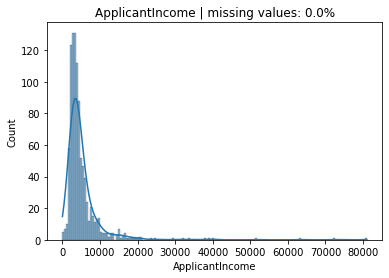

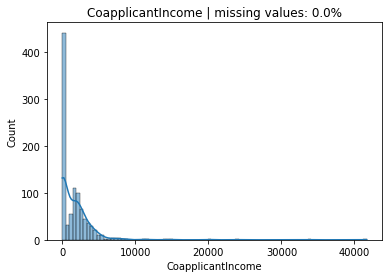

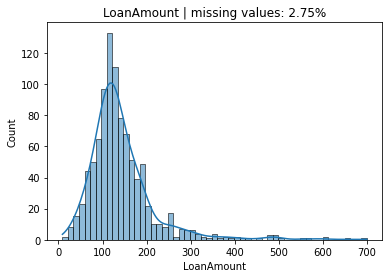

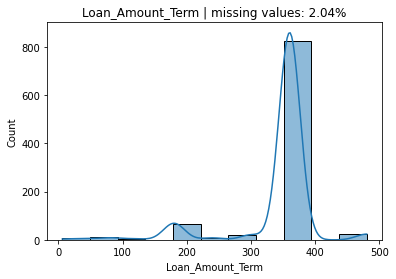

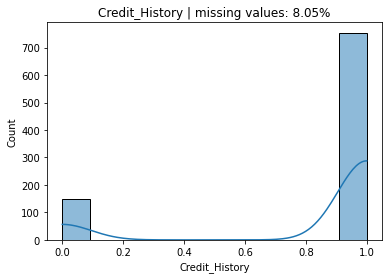

In [144]:
histplots_info(num)

Loan_Amount_Term и Credit_History - категориальные

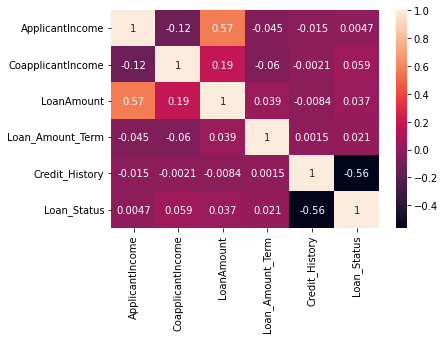

In [59]:
temp = pd.concat([train_num, target.map({'Y': 0, 'N': 1})], axis=1)

sns.heatmap(temp.corr(), annot=True)

Credit History - сильная фича, другие - относительно слабые

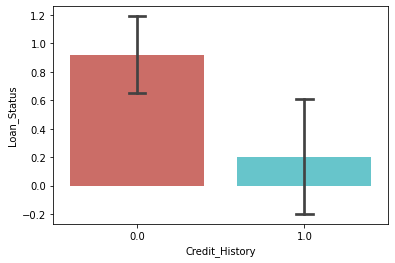

In [101]:
sns.barplot(x='Credit_History', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

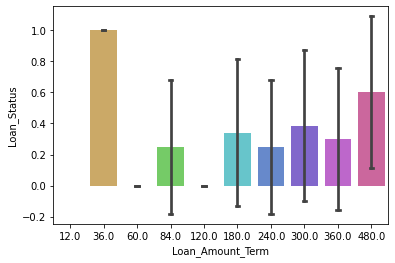

In [92]:
sns.barplot(x='Loan_Amount_Term', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

In [104]:
temp['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

Для некоторых категорий просто не хватает записей. Например для 12, 36, 60 и 120. В целом для категорий от 84 до 360 примерно одинаковая вероятность. для 480 она повыше


Для "начальных" дат есть смысл обьединить их в одну категорию, условно: краткосрочные кредиты. Последующие даты тоже можно сгрупировать. Выполню **по годам**

In [235]:
temp['Group_Loan_Amount_Term'] = temp['Loan_Amount_Term'].copy()

temp['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term'].replace([12.0, 36.0, 60.0, 84.0, 120.0], '<= 10 years')
temp['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term'].replace(180.0, '15 years')
temp['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term'].replace(360.0, '30 years')
temp['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term'].replace([240.0, 300.0], 'Not beautiful dates')
temp['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term'].replace([480.0], '40 years')

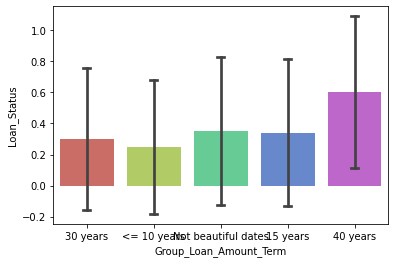

In [236]:
sns.barplot(x='Group_Loan_Amount_Term', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

Видим, что средний процент "увеличивается" с ростом времени по кредиту. Причём люди склонны больше брать долгосрочные кредиты (больше 10 лет) на даты, делящееся на 15 (15 лет, 30 лет). По ним больше всего кредитов, но процент примерно равен. На "некрасивых" датах процент самый высокий, и это интересно. Возможно это влияние 20 лет, но другие категории ничего не испортили.

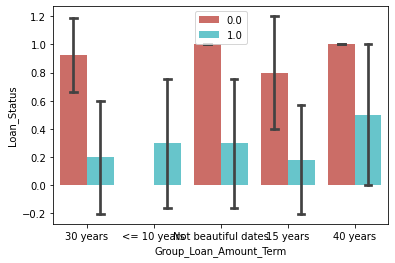

In [216]:
sns.barplot(x='Group_Loan_Amount_Term', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd',
            hue='Credit_History')
plt.legend(loc='upper center')

А вот это уже интересно. Для людей до 10 лет включительно вообще нет хорошей кредитной истории. При этом люди с "плохой" историей скорее возьмут кредит на некрасивый срок. Пропорции по 15 и 30 годам примерно равные, но для 30 лет большая уверенность в возвращении. 

In [217]:
temp.isnull().sum()

ApplicantIncome                0
CoapplicantIncome              0
LoanAmount                    22
Loan_Amount_Term              14
Credit_History                50
Loan_Status                    0
Group_Loan_Amount_Term        14
ApplicantIncome_Outliers       0
CoapplicantIncome_Outliers     0
LoanAmount_Outliers            0
dtype: int64

In [218]:
num.isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           27
Loan_Amount_Term     20
Credit_History       79
dtype: int64

Выполним заполнение на тренировочном, распостраним на тестовый позже !

**Много нулей на Кредит Нистори** - это проблема, думаю просто mode или mean заполнять не стоит, заполню с помощью моделей. После создания всех фичей. Также само поступлю со ** Сроком Кредита**.

Для **Количества Кредита** заполню средним - там нормальное распр

In [179]:
for col in ['ApplicantIncome', 'LoanAmount']:

      Q1 = np.nanpercentile(temp[col], 25)
      Q3 = np.nanpercentile(temp[col], 75)
      IQR = Q3 - Q1
      
      temp['{}_Outliers'.format(col)] = temp[col].map(lambda x: 'Normal' if x <= Q3 + 1.5 * IQR else 'Outlier') 
      # # temp[col > Q3 + 1.5 * IQR].groupby(col).mean()['Loan_Status']
      # print(temp[temp[col] > Q3 + 1.5 * IQR]['Loan_Status'].mean())

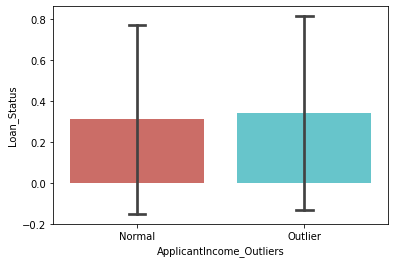

In [180]:
sns.barplot(x='ApplicantIncome_Outliers', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

In [181]:
temp['ApplicantIncome_Outliers'].value_counts()

Normal     564
Outlier     50
Name: ApplicantIncome_Outliers, dtype: int64

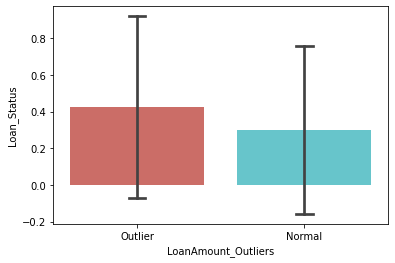

In [183]:
sns.barplot(x='LoanAmount_Outliers', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

In [184]:
temp['LoanAmount_Outliers'].value_counts()

Normal     553
Outlier     61
Name: LoanAmount_Outliers, dtype: int64

In [186]:
temp['CoapplicantIncome_Outliers'] = temp['CoapplicantIncome'].map(lambda x: 'Normal' if x <= 6700 else 'Outlier')

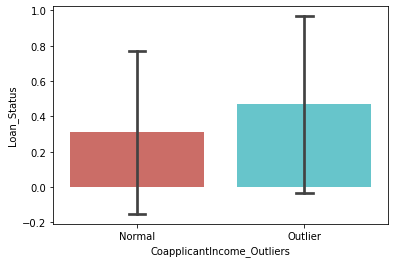

In [187]:
sns.barplot(x='CoapplicantIncome_Outliers', y='Loan_Status', data=temp,
            palette = 'hls', capsize = 0.1, ci = 'sd')

In [188]:
temp['CoapplicantIncome_Outliers'].value_counts()

Normal     599
Outlier     15
Name: CoapplicantIncome_Outliers, dtype: int64

## Categorical features

In [194]:
cat.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

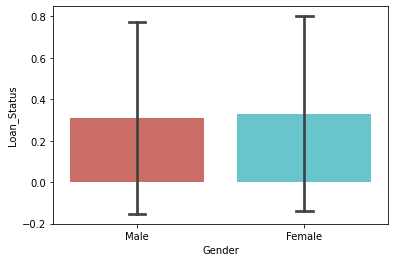

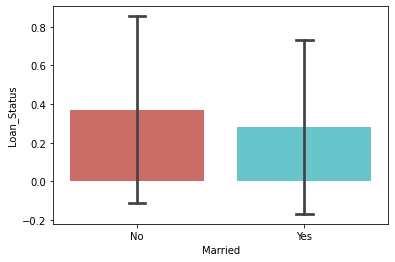

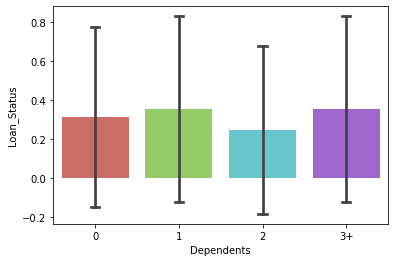

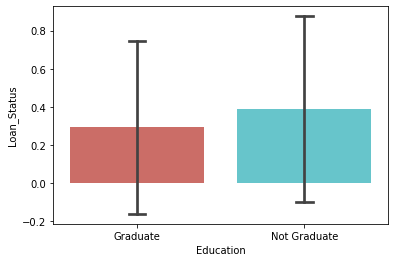

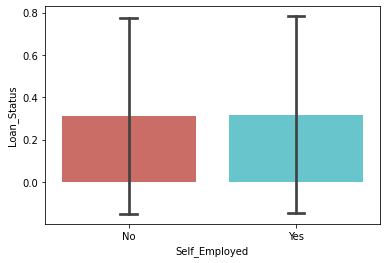

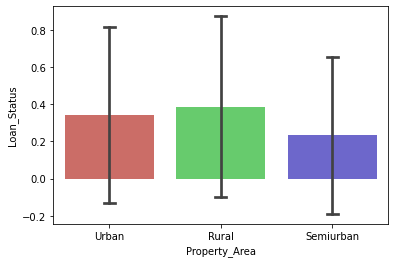

In [805]:
temp_ = pd.concat([train_cat, temp['Group_Loan_Amount_Term'], target.map({'Y': 0, 'N': 1})], axis=1)

for col in ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']:
  sns.barplot(x=col, y='Loan_Status', data=temp_,
            palette = 'hls', capsize = 0.1, ci = 'sd')
  plt.show()

Loan ID - будем использовать в качестве "рвндомной" фичи. Всё, что ниже - мусор.

Интересно посмотреть на влияние **Срока кредита** от **Вида дома**, **Влияния женат / не женат**, и других

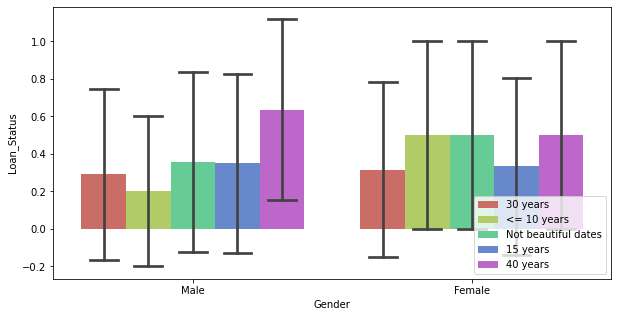

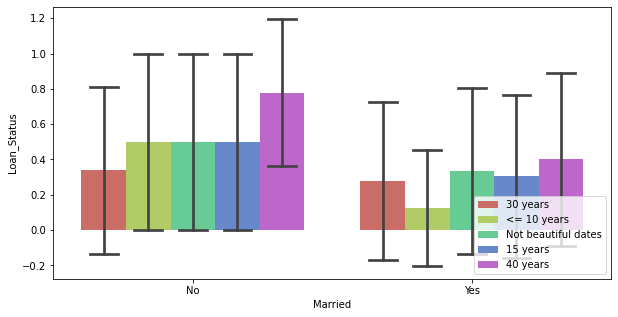

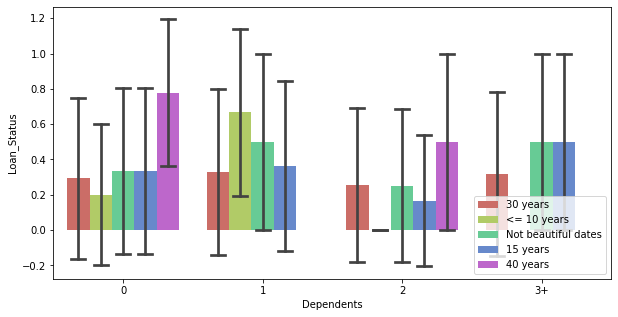

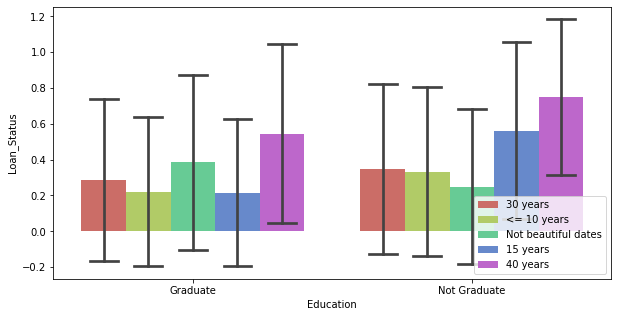

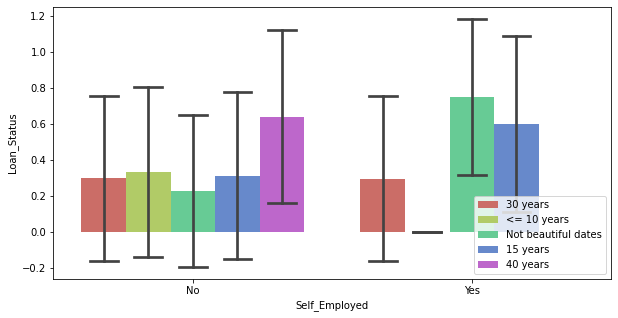

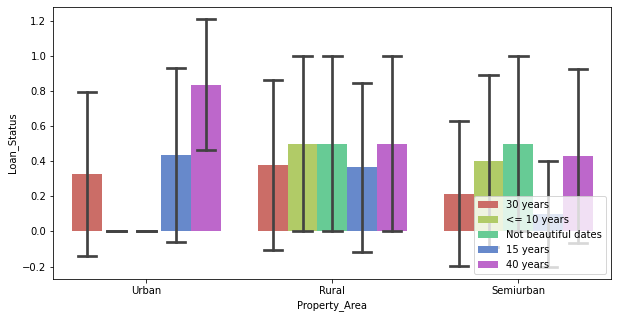

In [284]:
for col in ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']:
  plt.figure(figsize=(10, 5))
  sns.barplot(x=col, y='Loan_Status', data=temp_,
            palette = 'hls', capsize = 0.1, ci = 'sd', hue='Group_Loan_Amount_Term')
  plt.legend(loc='lower right')
  plt.show()

In [285]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://assets.ltkcontent.com/images/85044/rural-urban-suburban_0066f46bde.jpg")

Время генерить фичи! 

Посмотрим насколько они хороши

Предлагаю сначала заполнить нули, и удалить выбросы в нужных для нас колонках. **Пока только для тренировочного** 

In [806]:
cat.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [807]:
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  impute(train_cat, cat, 'mode')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [808]:
cat_dummies = pd.DataFrame()
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  cat_dummies = pd.concat([cat_dummies, pd.get_dummies(data=train_cat[col], drop_first=True, prefix=col)], axis=1)

In [809]:
cat_dummies = pd.concat([cat_dummies, target.map({'Y': 0, 'N': 1})], axis=1)

Заполяняем средним в **Loan Amount**

In [810]:
train_num['LoanAmount'] = train_num['LoanAmount'].fillna(train_num['LoanAmount'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Cначала Loan Term Imputation**. Потом будет больше инфы для более сильной **Credit History** 

** **спойлер**: ничего не вышло. Не хочу тратить на это время. Все классификаторы заполняют модой(360 месяцев)

In [811]:
train_num['Loan_Amount_Term'] = train_num['Loan_Amount_Term'].fillna(360.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Заполняем **Credit History**.

In [812]:
RS=4

ch = train_num['Credit_History']
X_ch = pd.concat([train_num.drop(['Credit_History'], axis=1), cat_dummies], axis=1)

sc = MinMaxScaler()

X_ch = pd.DataFrame(data=sc.fit_transform(X_ch), columns=X_ch.columns)

X_ch['Loan_Amount_Term'] = X_ch['Loan_Amount_Term'].fillna(360.0)
X_ch['LoanAmount'] = X_ch['LoanAmount'].fillna(X_ch['LoanAmount'].mean())

# X_term['Credit_History'] = X_term['Credit_History'].astype('float64')

ch_to_train_test =  ch[~ch.isna()]
ch_to_predict =  ch[ch.isna()]

X_ch_to_train_test =  X_ch[~ch.isna()]
X_ch_to_predict =  X_ch[ch.isna()]


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_ch_to_train_test, ch_to_train_test, 
                                                    test_size=0.2, random_state=RS)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


print(knn.score(X_test, y_test))
print(knn.score(X_train, y_train))

print(confusion_matrix(y_test, knn.predict(X_test)))
print(confusion_matrix(y_train, knn.predict(X_train)))

print(classification_report(y_test, knn.predict(X_test)))
print(classification_report(y_train, knn.predict(X_train)))

0.9026548672566371
0.8736141906873615
[[ 9  8]
 [ 3 93]]
[[ 35  37]
 [ 20 359]]
              precision    recall  f1-score   support

         0.0       0.75      0.53      0.62        17
         1.0       0.92      0.97      0.94        96

    accuracy                           0.90       113
   macro avg       0.84      0.75      0.78       113
weighted avg       0.90      0.90      0.90       113

              precision    recall  f1-score   support

         0.0       0.64      0.49      0.55        72
         1.0       0.91      0.95      0.93       379

    accuracy                           0.87       451
   macro avg       0.77      0.72      0.74       451
weighted avg       0.86      0.87      0.87       451



Лучший выбор - KNN(5). Удивительно, но оверфита нет.

In [813]:
X_ch['Credit_History'] = ch
X_ch['Credit_History'][X_ch['Credit_History'].isna()] = knn.predict(X_ch.drop(['Credit_History'], axis=1))

temp_['Credit_History'] = X_ch['Credit_History']

**Доход в семье на одного человека умножаем на срок дейсвия кредита. Соотносим цифры.**

In [799]:
# temp_['Dependents'] = temp_['Dependents'].fillna(0)
# temp_['Dependents'] = temp_['Dependents'].replace('3+', 3.5)
# temp_['Dependents'] = temp_['Dependents'].astype('float')

# temp_['Dependents'].value_counts()

In [788]:
# temp_['Medium_Family_Income'] = (temp['ApplicantIncome'] + temp['CoapplicantIncome']) / (temp_['Dependents'] + 1)

In [800]:
# sns.histplot(temp_['Medium_Family_Income'])

In [801]:
# temp_['Stable_Medium_Family_Income'] = temp_['Medium_Family_Income'] * temp['Loan_Amount_Term']

In [802]:
# temp_['Is_Stable_Medium_Family_Income'] = 0.1*temp_['Stable_Medium_Family_Income'] - (temp['LoanAmount'] * 1000)

In [803]:
# sns.histplot(temp_['Is_Stable_Medium_Family_Income'])

In [804]:
# temp_[temp_['Is_Stable_Medium_Family_Income'] <= 0.8*1000000].mean()

Не сработало предположение, проверку "на дурака" проходят все. Ведь тут наивно предполагается, что человек будет стабильно до 40 лет получать одну и ту же зарплату. Нужно перед этим ввести понятие "риска" и использовать в качестве коэфициента.

**Быстро заполним нули в temp_**

In [821]:
temp_['Group_Loan_Amount_Term'] = temp_['Group_Loan_Amount_Term'].fillna(temp_['Group_Loan_Amount_Term'].mode()[0])
temp_['Group_Loan_Amount_Term'].isnull().sum()

0

**Risk feature**

Family_Risk_Feature

In [1087]:
def family_risk(col):
  
  index = 1

  #Разведённые женщины и просто неженетые люди
  if col['Married'] == 'No':
    index *= 2/3
    if (col['Dependents'] != '0') & (col['Gender'] == 'Female'):
      index *= 1/2

  # #Неженатые мужики 
  # if col['Married'] == 'No':
  #   index *= 2/3
  #   if (col['Dependents'] != '0') & (col['Gender'] == 'Female'):
  #     index *= 1/2


  


  return index

fr = [family_risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Family_Risk'] = fr
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.118465,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.035785,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.739068,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.624329,0.387311
Family_Work_Mean_Risk,-0.118465,0.035785,0.739068,0.624329,1.000000,0.650295
Risk,-0.154660,0.037664,0.494161,0.387311,0.650295,1.000000


Почти 8%, неплохо

Work_Risk_feature

In [1088]:
def work_risk(col):
  
  index = 1

  if col['Education'] != 'Graduate':
    index *= 2/3
    if col['Self_Employed'] is 'Yes':
      index *= 1/2

  return index

wr = [work_risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Work_Risk'] = wr
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.118465,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.035785,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.739068,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.624329,0.387311
Family_Work_Mean_Risk,-0.118465,0.035785,0.739068,0.624329,1.000000,0.650295
Risk,-0.154660,0.037664,0.494161,0.387311,0.650295,1.000000


Больше 8%, еще лучше

Ищем среднее

In [1089]:
temp_['Family_Work_Mean_Risk'] = (temp_['Family_Risk'] + temp_['Work_Risk']) / 2
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.128882,-0.154660
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.047521,0.037664
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.792839,0.494161
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.601239,0.387311
Family_Work_Mean_Risk,-0.128882,0.047521,0.792839,0.601239,1.000000,0.630942
Risk,-0.154660,0.037664,0.494161,0.387311,0.630942,1.000000


Еще лучше, ничего себе 

Делаем индикаторы по аутлаерам и кредит истории

In [1090]:
temp_['LoanAmount_Outliers'] = temp['LoanAmount_Outliers'] 
temp_['ApplicantIncome_Outliers'] = temp['ApplicantIncome_Outliers']
temp_['CoapplicantIncome_Outliers'] = temp['CoapplicantIncome_Outliers']
temp_['Group_Loan_Amount_Term'] = temp['Group_Loan_Amount_Term']

In [1091]:
def risk(col):
  
  index = col['Family_Work_Mean_Risk']

  if col['Group_Loan_Amount_Term'] == '40 years':
    index *= 0.75

  if col['LoanAmount_Outliers'] == 'Outlier':
    index *= 0.5

  if col['Property_Area'] == 'Rural':
    index *= 2/3

  # if col['Credit_History'] == 0:
  #   index *= 0.9

  return index

risk = [risk(temp_.iloc[i]) for i in range(len(temp_))]
temp_['Risk'] = risk
temp_.corr()

,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,Risk
Loan_Status,1.000000,-0.562034,-0.095780,-0.085884,-0.128882,-0.182089
Credit_History,-0.562034,1.000000,-0.003047,0.081967,0.047521,0.045415
Family_Risk,-0.095780,-0.003047,1.000000,-0.010292,0.792839,0.357440
Work_Risk,-0.085884,0.081967,-0.010292,1.000000,0.601239,0.292755
Family_Work_Mean_Risk,-0.128882,0.047521,0.792839,0.601239,1.000000,0.464057
Risk,-0.182089,0.045415,0.357440,0.292755,0.464057,1.000000


Круто, сначала думал, что вообще на 42% нашел фичу, но не совсем. 

Корреляция перетекала из кредитной истории. Если вообще убрать влияние истории - будет не 23, а 15. Это тоже отличный результат! Нагенерил неплохую фичу из ничего. Небольшое влияние истории оставил (домножаю на 0.9)


In [1099]:
temp_.iloc[-10:, :]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Group_Loan_Amount_Term,Loan_Status,Credit_History,Family_Risk,Work_Risk,Family_Work_Mean_Risk,LoanAmount_Outliers,ApplicantIncome_Outliers,CoapplicantIncome_Outliers,Risk
604,LP002959,Female,Yes,1,Graduate,No,Semiurban,30 years,0,1.0,1.000000,1.000000,1.000000,Outlier,Outlier,Normal,0.500000
605,LP002960,Male,Yes,0,Not Graduate,No,Urban,15 years,1,1.0,1.000000,0.666667,0.833333,Outlier,Normal,Normal,0.416667
606,LP002961,Male,Yes,1,Graduate,No,Semiurban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
607,LP002964,Male,Yes,2,Not Graduate,No,Rural,30 years,0,1.0,1.000000,0.666667,0.833333,Normal,Normal,Normal,0.555556
608,LP002974,Male,Yes,0,Graduate,No,Rural,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,0.666667
609,LP002978,Female,No,0,Graduate,No,Rural,30 years,0,1.0,0.666667,1.000000,0.833333,Normal,Normal,Normal,0.555556
610,LP002979,Male,Yes,3+,Graduate,No,Rural,15 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,0.666667
611,LP002983,Male,Yes,1,Graduate,No,Urban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
612,LP002984,Male,Yes,2,Graduate,No,Urban,30 years,0,1.0,1.000000,1.000000,1.000000,Normal,Normal,Normal,1.000000
613,LP002990,Female,No,0,Graduate,Yes,Semiurban,30 years,1,0.0,0.666667,1.000000,0.833333,Normal,Normal,Normal,0.833333


Rural непонятный

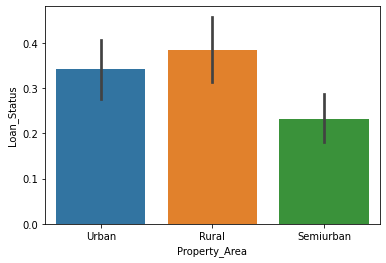

In [1086]:
sns.barplot(x='Property_Area', y='Loan_Status', data=temp_)

А ну посмотрим насколько **риск** хорош

In [1120]:
temp_[temp_['Risk'] <= 0.25]['Loan_Status']

338    1
Name: Loan_Status, dtype: int64

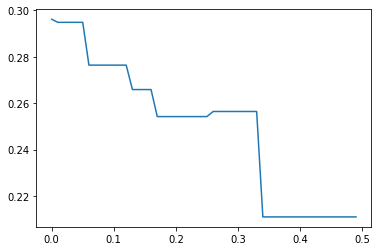

In [1125]:
lst = np.array([temp_[temp_['Risk'] >= 0.5+i]['Loan_Status'].mean() for i in np.arange(0, 0.5, 0.01)])
lst_len = np.array([len(temp_[temp_['Risk'] >= 0.5+i]['Loan_Status']) for i in np.arange(0, 0.5, 0.01)])

plt.plot(np.arange(0, 0.5, 0.01), lst)

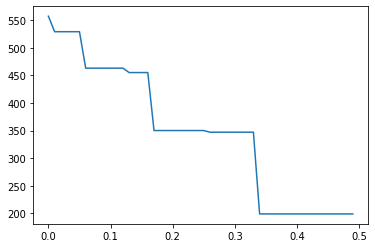

In [1126]:
plt.plot(np.arange(0, 0.5, 0.01), lst_len)